# Machine Learning in Apache Iceberg

In [1]:
from pyspark.sql import SparkSession
import os

In [2]:
spark = (
    SparkSession.builder
    .appName("Machine Learning in Iceberg")
    .master("spark://spark:7077") 
    .getOrCreate()
)

First, we gather the features used to determine what spending category they will likely be in based on the data

In [3]:
features_df = spark.sql("""
SELECT
    o.customer_id,
    COUNT(DISTINCT o.id) AS total_orders,
    COUNT(DISTINCT oi.product_id) AS unique_products,
    SUM(oi.quantity) AS total_items,
    ROUND(SUM(oi.quantity * p.price), 2) AS total_spent
FROM ice.demo.orders o
JOIN ice.demo.order_items oi ON o.id = oi.order_id
JOIN ice.demo.products p ON oi.product_id = p.product_id
GROUP BY o.customer_id
""")

Next, we convert it into panel data so that we can use this notebook platform

In [4]:
import pandas as pd

df = features_df.toPandas()
df.head()

,customer_id,total_orders,unique_products,total_items,total_spent
0,12,3,5,15,1559.85
1,22,2,3,13,729.87
2,1,3,4,18,1859.82
3,13,3,5,19,914.81
4,6,3,5,15,1309.85


Here we are applying the target, or spending class

In [5]:
import numpy as np

quantiles = df["total_spent"].quantile([0.33, 0.66]).values
low, high = quantiles

def spending_class(amount):
    if amount < low:
        return "Low"
    elif amount < high:
        return "Medium"
    else:
        return "High"

df["spend_category"] = df["total_spent"].apply(spending_class)
df.head()

,customer_id,total_orders,unique_products,total_items,total_spent,spend_category
0,12,3,5,15,1559.85,High
1,22,2,3,13,729.87,Low
2,1,3,4,18,1859.82,High
3,13,3,5,19,914.81,Medium
4,6,3,5,15,1309.85,High


Now we are applying a confusion matrix to see if the classification were indeed what we expected

              precision    recall  f1-score   support

        High       0.20      1.00      0.33         1
         Low       1.00      0.33      0.50         3
      Medium       0.00      0.00      0.00         3

    accuracy                           0.29         7
   macro avg       0.40      0.44      0.28         7
weighted avg       0.46      0.29      0.26         7



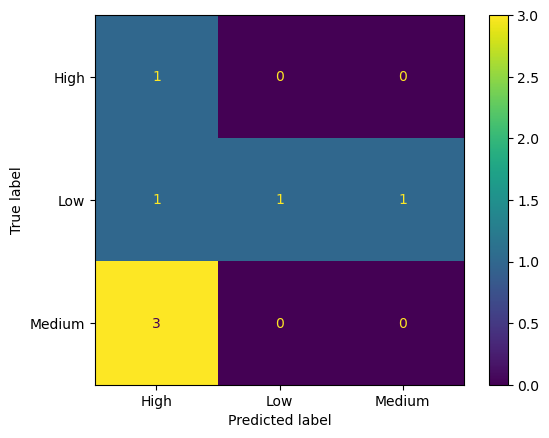

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

X = df[["total_orders", "unique_products", "total_items"]]
y = df["spend_category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test);

Here we are showing the importances of the classification

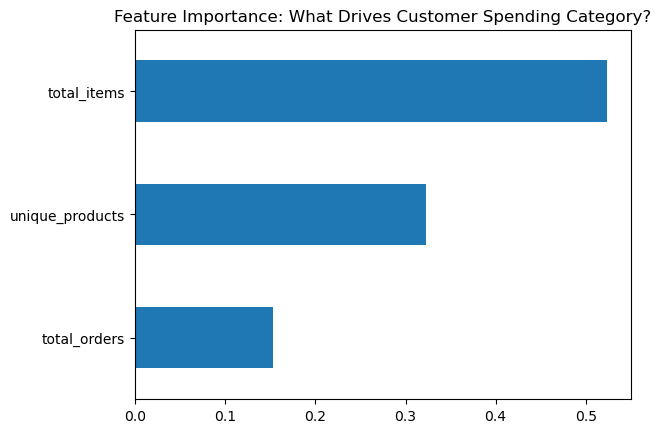

In [12]:
import matplotlib.pyplot as plt

importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot.barh()
plt.title("Feature Importance: What Drives Customer Spending Category?")
plt.show();

Finally, here we are making a prediction

In [13]:
example = pd.DataFrame([[5, 12, 30]], columns=["total_orders", "unique_products", "total_items"])
print("Predicted class:", clf.predict(example)[0])

Predicted class: High


In [14]:
spark.stop()